In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to load the dataset and extract metadata
def extract_metadata(dataset_path):
    data = []
    class_distribution = {}

    # Loop through each class directory
    for class_dir in os.listdir(dataset_path):
        # Skip hidden files or directories (e.g., .DS_Store on macOS)
        if class_dir.startswith('.'):
            continue

        # Use the directory name as the class label (no conversion to int)
        class_id = class_dir
        class_images = os.listdir(os.path.join(dataset_path, class_dir))

        # Count the number of images in the class directory
        class_distribution[class_id] = len(class_images)
        data.append((class_id, len(class_images)))

    # Convert data to DataFrame for easier manipulation and visualization
    df = pd.DataFrame(data, columns=['ClassID', 'NumImages'])

    # Calculate total number of images
    total_images = df['NumImages'].sum()

    # Display metadata
    print("Metadata Summary:")
    print("=================")
    print("Total number of images:", total_images)
    print("Number of classes:", len(df))
    print("Class distribution:")
    print(df)
    print("")

    return df, class_distribution

# # Path to the dataset
# dataset_path = "IndianSignLanguage/data"

# # Extract metadata
# metadata_df, class_distribution = extract_metadata(dataset_path)

# # Plot the data distribution based on class ID
# plt.figure(figsize=(10, 6))
# plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
# plt.xlabel('Class ID')
# plt.ylabel('Number of Images')
# plt.title('Data Distribution Based on Class ID')
# plt.xticks(rotation=90)  # Rotate x-axis labels if there are many classes
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import pandas as pd
# import cv2
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

In [19]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Suppress the warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to the GPU
            images, labels = images.to(device), labels.to(device)

            # Get model outputs and predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU

    # Calculate evaluation metrics
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division='warn')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)

    return accuracy, f1, recall, precision


In [21]:
# Lists to store training loss and metrics
training_loss_arr = [[] for _ in range(3)]  # Store loss for each dataset
accuracy_arr = [[] for _ in range(3)]  # Store accuracy for each dataset
f1_arr = [[] for _ in range(3)]  # Store F1 score for each dataset
recall_arr = [[] for _ in range(3)]  # Store recall for each dataset
precision_arr = [[] for _ in range(3)]  # Store precision for each dataset
# roc = [[] for _ in range(3)]  # Store roc for each dataset
epocs =10
train_loaders_arr = [0, 1, 2]

In [13]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [1]:
import requests
import zipfile
import os

# URL of the dataset with direct download
url = 'https://www.dropbox.com/scl/fi/7o8eil59unj7vsxws6zgo/Sign-Language-Digits-Dataset-master-1.zip?rlkey=l3hrprqn03ts03ulbth2216w0&st=c1k4gdpw&dl=1'

# Download the file
response = requests.get(url)

# Check if the response is successful
if response.status_code == 200:
    zip_path = 'Sign-Language-Digits-Dataset-master.zip'

    # Save the ZIP file
    with open(zip_path, 'wb') as f:
        f.write(response.content)

    print("Dataset downloaded successfully.")

    # Verify if the file is a valid zip file
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.testzip()  # Test the zip file integrity
            zip_ref.extractall('Sign-Language-Digits-Dataset-master')
            print("Dataset extracted successfully.")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file.")
else:
    print(f"Error downloading the dataset. Status code: {response.status_code}")


Dataset downloaded successfully.
Dataset extracted successfully.


Metadata Summary:
Total number of images: 2062
Number of classes: 10
Class distribution:
  ClassID  NumImages
0       4        207
1       1        206
2       0        205
3       6        207
4       7        206
5       9        204
6       5        207
7       3        206
8       2        206
9       8        208



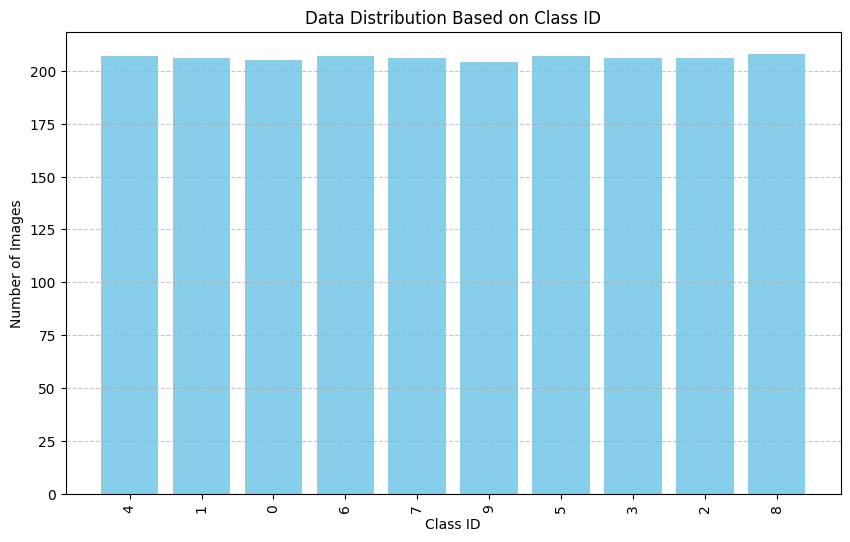

In [7]:
# Path to the dataset
dataset_path = "Sign-Language-Digits-Dataset-master/Sign-Language-Digits-Dataset-master/Dataset"

# Extract metadata
metadata_df, class_distribution = extract_metadata(dataset_path)

# Plot the data distribution based on class ID
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Data Distribution Based on Class ID')
plt.xticks(rotation=90)  # Rotate x-axis labels if there are many classes
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Exploratory Analysis:
Metadata Summary:
Total number of images: 2062
Number of classes: 10
Class distribution:
  ClassID  NumImages
0       4        207
1       1        206
2       0        205
3       6        207
4       7        206
5       9        204
6       5        207
7       3        206
8       2        206
9       8        208



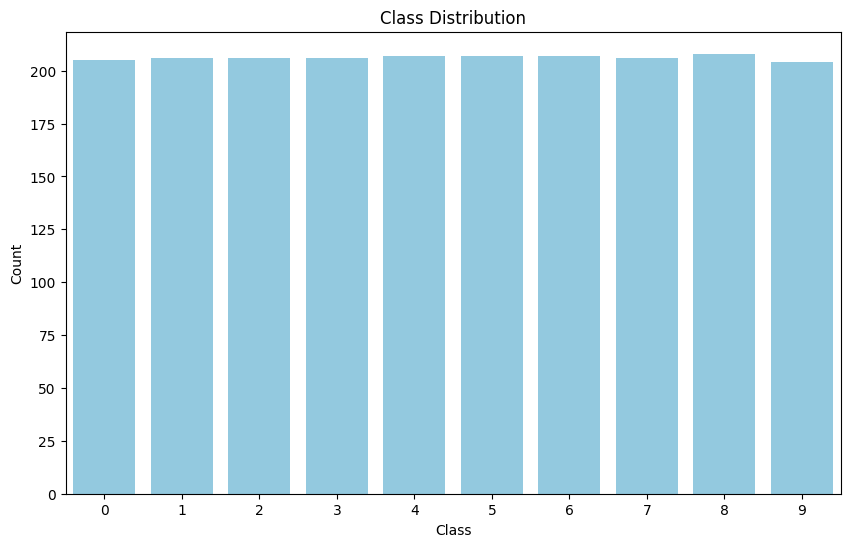

In [8]:
import os
import shutil
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# Define paths
source_dir = "Sign-Language-Digits-Dataset-master/Sign-Language-Digits-Dataset-master/Dataset"
target_dir = "Sign-Language-Digits-Dataset-master_processed"

# Create target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Define classes to keep (adjust as needed for your dataset)
# Here, classes can be set as specific folder names you want to keep.
classes_to_keep = os.listdir(source_dir)  # Keeps all classes in the dataset

# Copy images of selected classes to the target directory
for class_name in classes_to_keep:
    src_path = os.path.join(source_dir, class_name)
    dst_path = os.path.join(target_dir, class_name)
    try:
        shutil.copytree(src_path, dst_path)
    except FileExistsError:
        print(f"Directory '{dst_path}' already exists. Skipping copying.")

# Dataset Paths
data_dir = target_dir

# Extract metadata
# Exploratory Analysis
print("Exploratory Analysis:")
metadata_df, class_distribution = extract_metadata(data_dir)

# Image transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Random horizontal flip
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset with augmented transform
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Convert to DataFrame
df = pd.DataFrame(dataset.imgs, columns=['image_path', 'label'])

# Distribution Graphs
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [11]:
# Set the random seed
# torch.manual_seed(42)
# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
vgg = models.vgg16(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
num_classes = 10
vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.001)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the pre-trained VGG16 model
vgg = models.vgg16(pretrained=True)

# Freeze the feature extractor layers
for param in vgg.features.parameters():
    param.requires_grad = False

# Modify the classifier for the new number of classes
num_classes = 35
vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.classifier.parameters(), lr=0.001)  # Train only classifier layers


In [22]:
# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    vgg.train()  # Set the model to training mode
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()  # Zero the gradients
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # Print loss for the epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}")

    # Evaluate the model
    acc, f1_val, recall_val, precision_val = evaluate_model(vgg, test_loader, device)

    # Save metrics
    accuracy_arr[0].append(acc)
    f1_arr[0].append(f1_val)
    recall_arr[0].append(recall_val)
    precision_arr[0].append(precision_val)

# Print the metrics
print("Accuracy:", accuracy_arr)
print("F1 Score:", f1_arr)
print("Recall:", recall_arr)
print("Precision:", precision_arr)

print("Finished Training")


Epoch 1, Loss: 0.958
Epoch 2, Loss: 0.780
Epoch 3, Loss: 0.699
Epoch 4, Loss: 0.731
Epoch 5, Loss: 0.734
Epoch 6, Loss: 0.721
Epoch 7, Loss: 0.665
Epoch 8, Loss: 0.631
Epoch 9, Loss: 0.704
Epoch 10, Loss: 0.679
Accuracy: [[0.7754442649434572, 0.7722132471728594, 0.7705977382875606, 0.7609046849757674, 0.7302100161550888, 0.7996768982229402, 0.7964458804523424, 0.7964458804523424, 0.7722132471728594, 0.7851373182552503], [], []]
F1 Score: [[0.7748448601330026, 0.773447013820851, 0.762412334693803, 0.752425842566736, 0.7073168451885501, 0.8011548762762978, 0.795729296338013, 0.7932243844086466, 0.761131856308922, 0.7815179822408306], [], []]
Recall: [[0.7754442649434572, 0.7722132471728594, 0.7705977382875606, 0.7609046849757674, 0.7302100161550888, 0.7996768982229402, 0.7964458804523424, 0.7964458804523424, 0.7722132471728594, 0.7851373182552503], [], []]
Precision: [[0.7839128011122897, 0.7913719958902168, 0.7896179300473337, 0.7830058998316621, 0.793377864510052, 0.8132857832800847, 0

In [ ]:
import torch
import torch.nn as nn

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
net = VGG11(num_classes=10).to(device)  # Move the model to the GPU

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)


# Clear all values in the arrays
accuracy_arr[1].clear()
f1_arr[1].clear()
recall_arr[1].clear()
precision_arr[1].clear()

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels and move them to the GPU
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # Print loss for the epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}")

    # Evaluate the model
    acc, f1_val, recall_val, precision_val = evaluate_model(net, test_loader,device)  # Assuming test_loader is defined

    # Save metrics
    accuracy_arr[1].append(acc)
    f1_arr[1].append(f1_val)
    recall_arr[1].append(recall_val)
    precision_arr[1].append(precision_val)

# Print the metrics
print("Accuracy:", accuracy_arr)
print("F1 Score:", f1_arr)
print("Recall:", recall_arr)
print("Precision:", precision_arr)

print("Finished Training")


Epoch 1, Loss: 1.812
Epoch 2, Loss: 1.563
Epoch 3, Loss: 0.530
Epoch 4, Loss: 0.234
Epoch 5, Loss: 0.262
Epoch 6, Loss: 0.144
Epoch 7, Loss: 0.031
Epoch 8, Loss: 0.015
Epoch 9, Loss: 0.030
Epoch 10, Loss: 0.007
Accuracy: [[0.2149035790810253, 0.5698754067137529, 0.8779461947464487, 0.950321403063249, 0.9292913260852314, 0.959368304102849, 0.989683358463614, 0.9269105626537576, 0.9917466867708912, 0.9952384731370526], [0.09369951534733441, 0.6882067851373183, 0.877221324717286, 0.8820678513731826, 0.9030694668820679, 0.9369951534733441, 0.9563812600969306, 0.9321486268174475, 0.9466882067851373, 0.9499192245557351], []]
F1 Score: [[0.17928212770342494, 0.5232567552498828, 0.8701860021091185, 0.9484691545885786, 0.9270342833470889, 0.9588186734434561, 0.9896919741664159, 0.9262038058298047, 0.9917448961497187, 0.9952352436713324], [0.016054865258922885, 0.6742038932785401, 0.8753634752954984, 0.8841898459234274, 0.9026522625038769, 0.9375338568530686, 0.9563929371998351, 0.93290281613370

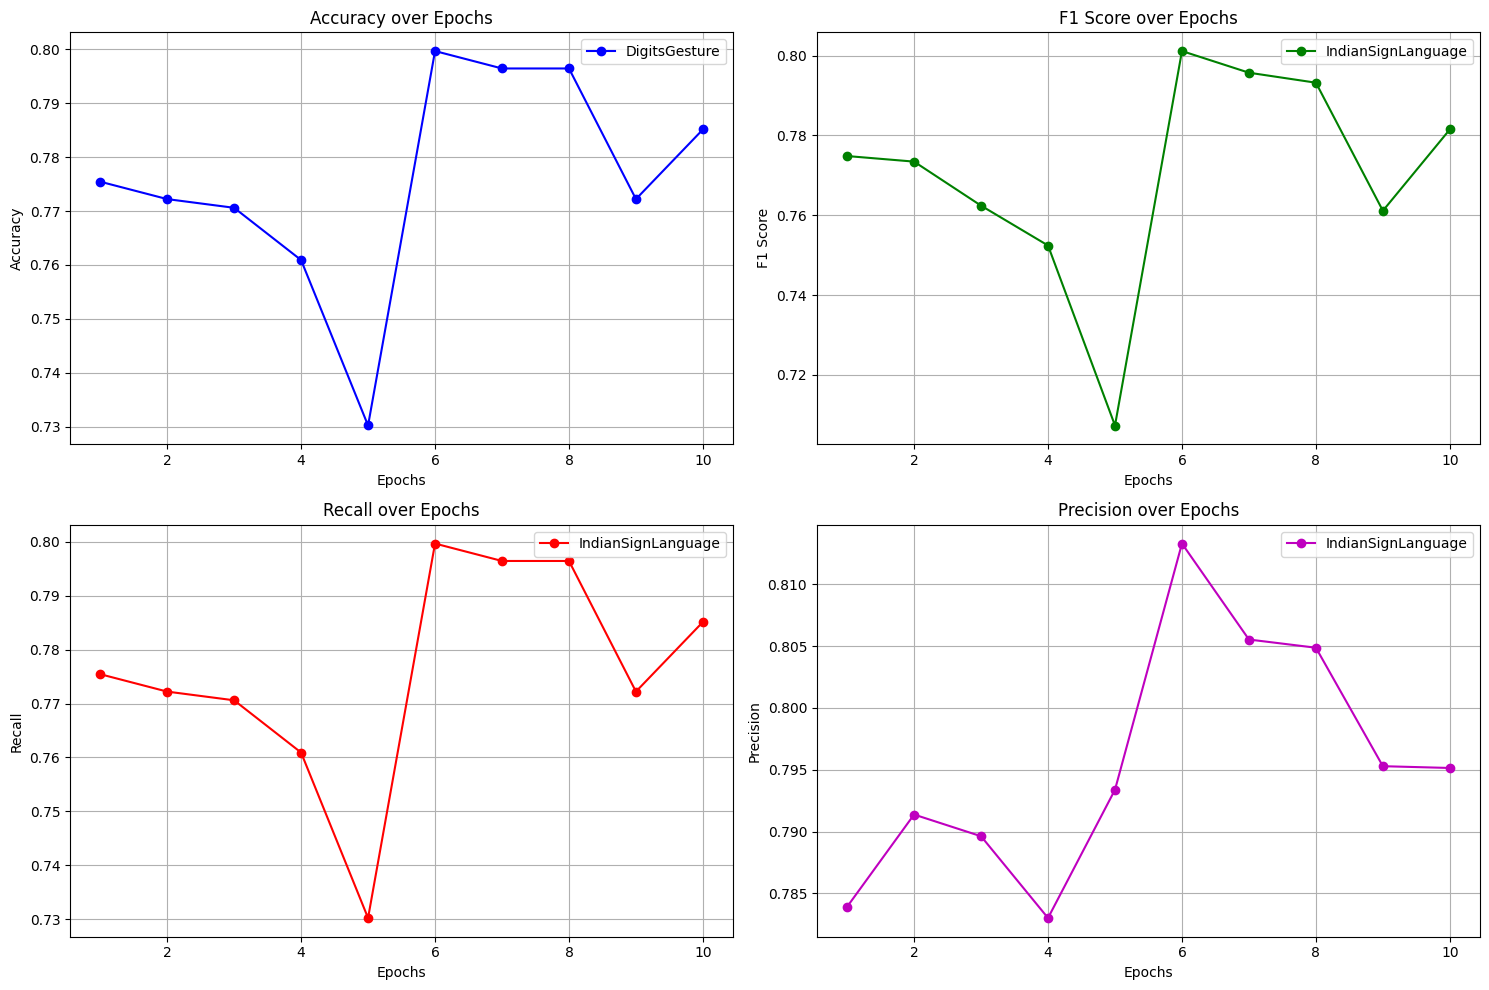

In [23]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, 11)  # Assuming you have 10 epochs

# Plotting function for a single dataset
def my_plot(epochs, accuracy_arr, f1_arr, recall_arr, precision_arr, label):
    plt.figure(figsize=(15, 10))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, accuracy_arr, label='DigitsGesture', marker='o', color='b')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot F1 Score
    plt.subplot(2, 2, 2)
    plt.plot(epochs, f1_arr, label='IndianSignLanguage', marker='o', color='g')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot Recall
    plt.subplot(2, 2, 3)
    plt.plot(epochs, recall_arr, label='IndianSignLanguage', marker='o', color='r')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    # Plot Precision
    plt.subplot(2, 2, 4)
    plt.plot(epochs, precision_arr, label='IndianSignLanguage', marker='o', color='m')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot
my_plot(epochs, accuracy_arr[0], f1_arr[0], recall_arr[0], precision_arr[0], 'DigitsGesture')
